## Topic: Predicting the outcome of a cricket match (win: 1, lose: 0)
## Step1: Read in the Data and Package

#### reference link:
https://www.cricketwa.com/article/76/the-hundred-cricket-venue.aspx#:~:text=Located%20at%20Leeds%2C%20England%2C%20the,the%20vast%20Headingley%20Stadium%20compound.

https://www.espncricinfo.com/series/the-hundred-men-s-competition-2021-1252040/manchester-originals-men-vs-southern-brave-men-19th-match-1252684/full-scorecard

In [177]:
#general
import pandas as pd
print(pd.__version__)

import numpy as np
import json
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

1.4.2


In [178]:
#Train Test Split
from sklearn.model_selection import train_test_split

#Models and Performance Metrics
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import make_pipeline

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score,classification_report
from sklearn.metrics import roc_curve, auc


from sklearn import svm

# # Neural Networks
# import torch
# import torchtext
# from torchtext.legacy import data #For handling text data
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F

#k-means
#interaction terms
#un :pca,k-means
#neural network to deepl leaning

In [179]:
folder_path = os.getcwd() + '/hnd_json/'  
data_frame_list = []

home_venues = {
    "Southern Brave": "The Rose Bowl, Southampton",
    "Birmingham Phoenix": "Edgbaston, Birmingham",
    "Trent Rockets": "Trent Bridge, Nottingham",
    "Oval Invincibles": "Kennington Oval, London",
    "London Spirit": "Lord's, London",
    "Welsh Fire": "Sophia Gardens, Cardiff",
    "Manchester Originals": "Old Trafford, Manchester",
    "Northern Superchargers": "Headingley, Leeds"
}


def get_team_scores(data_dict):
    team_scores = {}
    for innings in data_dict["innings"]:
        team = innings["team"]
        team_scores[team] = 0
        for over in innings["overs"]:
            for delivery in over["deliveries"]:
                team_scores[team] += delivery["runs"]["total"]
        if "target" in innings:
            # 如果有目标分数，就用目标分数更新第二个队伍的得分
            target_team = innings["team"]
            target_runs = innings["target"]["runs"]
            team_scores[target_team] = target_runs
    return team_scores


def calculate_halfway_scores(innings):
    halfway_score = 0
    halfway_wickets = 0
    delivery_count = 0

    for over in innings["overs"]:
        for delivery in over["deliveries"]:
            if delivery_count >= 50:
                return halfway_score, halfway_wickets

            halfway_score += delivery["runs"]["total"]
            if "wicket" in delivery:
                halfway_wickets += 1

            delivery_count += 1

    return halfway_score, halfway_wickets



for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        with open(os.path.join(folder_path, file_name), 'r') as f:
            data_dict = json.load(f)
            
            info_data = data_dict['info']

            team1 = info_data['teams'][0]
            team2 = info_data['teams'][1]
            
            gender = info_data['gender']
            season = info_data['season']
            
            date = info_data['dates'][0]
            
            match_number = info_data['event'].get('match_number', 'unknown')  
            
            venue = info_data['venue']
            city = info_data['city']
                    
            home_advantage_team1 = 'yes' if home_venues[team1] == venue else 'no'
            home_advantage_team2 = 'yes' if home_venues[team2] == venue else 'no'
            #home_advantage and toss_winner may be strong relationship          
            
            toss_winner = info_data['toss']['winner']
            toss_decision = info_data['toss']['decision']
            
            choose_to_bat, choose_to_field, forced_to_bat, forced_to_field = 'no', 'no', 'no', 'no'
            if toss_decision == 'bat':
                choose_to_bat = toss_winner
                forced_to_field = team1 if toss_winner == team2 else team2
            else:
                choose_to_field = toss_winner
                forced_to_bat = team1 if toss_winner == team2 else team2
            
            # Set the reverse decision for the losing team based on the toss decision
            toss_decision_loser = 'field' if toss_decision == 'bat' else 'bat'
            toss_decision_team1 = toss_decision if toss_winner == team1 else toss_decision_loser
            toss_decision_team2 = toss_decision if toss_winner == team2 else toss_decision_loser
            
            winner = info_data['outcome'].get('winner', 'no winner')  

            result_team1 = 'win' if winner == team1 else ('loose' if winner == team2 else 'no result')
            result_team2 = 'win' if winner == team2 else ('loose' if winner == team1 else 'no result')
            if result_team1 == 'no result' or result_team2 == 'no result':
                continue
            
            
            player_of_match = info_data.get('player_of_match', [])
            player_of_match_team1 = [player for player in player_of_match if player in info_data['players'][team1]]
            player_of_match_team2 = [player for player in player_of_match if player in info_data['players'][team2]]
            # checked which team's best player is on the list
            # Flatten the lists into single strings
            player_of_match_team1 = ', '.join(player_of_match_team1)
            player_of_match_team2 = ', '.join(player_of_match_team2)
            
            
            #umpires = info_data['officials'].get('umpires', [])
            #tv_umpires = info_data['officials'].get('tv_umpires', [])
            #reserve_umpires = info_data['officials'].get('reserve_umpires', [])
            #match_referees = info_data['officials'].get('match_referees', [])
            #all_umpires = umpires + tv_umpires + reserve_umpires + match_referees
            
    
            innings_data = data_dict['innings']
        
            team1_score = sum(delivery['runs']['total'] for innings in innings_data if innings['team'] == team1 for over in innings['overs'] for delivery in over['deliveries'])
            team2_score = sum(delivery['runs']['total'] for innings in innings_data if innings['team'] == team2 for over in innings['overs'] for delivery in over['deliveries'])

            team1_innings = next((innings for innings in innings_data if innings['team'] == team1), None)
            team2_innings = next((innings for innings in innings_data if innings['team'] == team2), None)
            if not team1_innings or not team2_innings:
                continue

            team1_halfway_score, team1_halfway_wickets = calculate_halfway_scores(team1_innings)
            team2_halfway_score, team2_halfway_wickets = calculate_halfway_scores(team2_innings)

              
            data_frame_list.append([result_team1, team1, team2, gender, season, date, match_number, venue, city, home_advantage_team1, 
                                    toss_winner, toss_decision_team1,choose_to_bat, choose_to_field, forced_to_bat, forced_to_field,  
                                    winner, team1_score, team1_halfway_score, team1_halfway_wickets,player_of_match_team1 ])
            
            data_frame_list.append([result_team2, team2, team1, gender, season, date, match_number, venue, city, home_advantage_team2, 
                                    toss_winner, toss_decision_team2,choose_to_bat, choose_to_field, forced_to_bat, forced_to_field, 
                                    winner,  team2_score, team2_halfway_score, team2_halfway_wickets,player_of_match_team2 ])

                  
        
df = pd.DataFrame(data_frame_list, columns=['Result', 'team', 'opponent', 'gender', 'season','date', 
                                            'match_number', 'venue', 'city', 'home_advantage',
                                            'toss_winner', 'toss_decision', 
                                            'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field',
                                            'winner','score', 
                                            'halfway_score', 'halfway_wickets',
                                            'player_of_match'])

In [180]:
df

,Result,team,opponent,gender,season,date,match_number,venue,city,home_advantage,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,winner,score,halfway_score,halfway_wickets,player_of_match
0,loose,Manchester Originals,Trent Rockets,male,2022,2022-09-03,unknown,"Lord's, London",London,no,...,bat,Manchester Originals,no,no,Trent Rockets,Trent Rockets,120,60,0,
1,win,Trent Rockets,Manchester Originals,male,2022,2022-09-03,unknown,"Lord's, London",London,no,...,field,Manchester Originals,no,no,Trent Rockets,Trent Rockets,121,50,0,SJ Cook
2,loose,Trent Rockets,Southern Brave,male,2022,2022-08-25,25,"The Rose Bowl, Southampton",Southampton,no,...,bat,no,Southern Brave,Trent Rockets,no,Southern Brave,138,59,0,
3,win,Southern Brave,Trent Rockets,male,2022,2022-08-25,25,"The Rose Bowl, Southampton",Southampton,yes,...,field,no,Southern Brave,Trent Rockets,no,Southern Brave,142,52,0,AL Davies
4,loose,Welsh Fire,Southern Brave,female,2021,2021-07-27,8,"Sophia Gardens, Cardiff",Cardiff,yes,...,bat,no,Southern Brave,Welsh Fire,no,Southern Brave,110,51,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,loose,Northern Superchargers,Birmingham Phoenix,female,2022,2022-08-19,11,"Edgbaston, Birmingham",Birmingham,no,...,field,no,Northern Superchargers,Birmingham Phoenix,no,Birmingham Phoenix,148,69,0,
242,win,Northern Superchargers,London Spirit,male,2021,2021-08-03,17,"Lord's, London",London,no,...,bat,Northern Superchargers,no,no,London Spirit,Northern Superchargers,155,69,0,DJ Willey
243,loose,London Spirit,Northern Superchargers,male,2021,2021-08-03,17,"Lord's, London",London,yes,...,field,Northern Superchargers,no,no,London Spirit,Northern Superchargers,92,54,0,
244,loose,Trent Rockets,Manchester Originals,female,2021,2021-08-15,29,"Trent Bridge, Nottingham",Nottingham,yes,...,bat,no,Manchester Originals,Trent Rockets,no,Manchester Originals,122,54,0,


There was one game where team2's half-time data was not found in the innings_data, probably because team2 did not play, which is the same game as one game no result, which was identified by the news that rain interrupted the game on that day, which is a very special case, so I chose to skip this game directly and created a data frame with only records This was a very special case, so I chose to skip the match and create a data frame with only 123 matches, or 246 rows of data.

In [181]:
# convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])

# sort by 'season' and 'date'
df = df.sort_values(by=['season', 'date'])

column_order = ['Result','score','halfway_score', 'halfway_wickets',
                'team', 'opponent', 
                'gender', 'season', 'date', 
                'match_number', 
                'venue', 'city', 'home_advantage',
                'toss_winner', 'toss_decision', 
                'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field',
                'winner','player_of_match']
                                            

df = df[column_order]
df = df.reset_index(drop=True)

In [182]:
df.head()

,Result,score,halfway_score,halfway_wickets,team,opponent,gender,season,date,match_number,...,city,home_advantage,toss_winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,winner,player_of_match
0,loose,135,59,0,Manchester Originals,Oval Invincibles,female,2021,2021-07-21,1,...,London,no,Manchester Originals,bat,Manchester Originals,no,no,Oval Invincibles,Oval Invincibles,
1,win,139,53,0,Oval Invincibles,Manchester Originals,female,2021,2021-07-21,1,...,London,yes,Manchester Originals,field,Manchester Originals,no,no,Oval Invincibles,Oval Invincibles,D van Niekerk
2,win,145,67,0,Oval Invincibles,Manchester Originals,male,2021,2021-07-22,1,...,London,yes,Manchester Originals,bat,no,Manchester Originals,Oval Invincibles,no,Oval Invincibles,SW Billings
3,loose,136,58,0,Manchester Originals,Oval Invincibles,male,2021,2021-07-22,1,...,London,no,Manchester Originals,field,no,Manchester Originals,Oval Invincibles,no,Oval Invincibles,
4,loose,128,53,0,Birmingham Phoenix,London Spirit,female,2021,2021-07-23,2,...,Birmingham,yes,London Spirit,bat,no,London Spirit,Birmingham Phoenix,no,London Spirit,E Jones


In [183]:
df.loc[df['match_number'] == 'unknown']
#Out of the group stage and into the semi-finals
df.loc[df['date'] == '2021-08-20', 'match_number'] = 40 
df.loc[df['date'] == '2022-09-02', 'match_number'] = 40
#Come to the final
df.loc[df['date'] == '2021-08-21', 'match_number'] = 50
df.loc[df['date'] == '2022-09-03', 'match_number'] = 50

Those without match numbers are semi-finals and finals, while the maximum match number for women's cricket in 2022 is known to be 22 and the maximum match number for all three types of matches, 2022 men, 2021 men and 2021 women, is 32.

To distinguish significantly between the semi-finals and finals, assign a value of 40 to the semi-finals and 50 to the finals

In [184]:
df

,Result,score,halfway_score,halfway_wickets,team,opponent,gender,season,date,match_number,...,city,home_advantage,toss_winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,winner,player_of_match
0,loose,135,59,0,Manchester Originals,Oval Invincibles,female,2021,2021-07-21,1,...,London,no,Manchester Originals,bat,Manchester Originals,no,no,Oval Invincibles,Oval Invincibles,
1,win,139,53,0,Oval Invincibles,Manchester Originals,female,2021,2021-07-21,1,...,London,yes,Manchester Originals,field,Manchester Originals,no,no,Oval Invincibles,Oval Invincibles,D van Niekerk
2,win,145,67,0,Oval Invincibles,Manchester Originals,male,2021,2021-07-22,1,...,London,yes,Manchester Originals,bat,no,Manchester Originals,Oval Invincibles,no,Oval Invincibles,SW Billings
3,loose,136,58,0,Manchester Originals,Oval Invincibles,male,2021,2021-07-22,1,...,London,no,Manchester Originals,field,no,Manchester Originals,Oval Invincibles,no,Oval Invincibles,
4,loose,128,53,0,Birmingham Phoenix,London Spirit,female,2021,2021-07-23,2,...,Birmingham,yes,London Spirit,bat,no,London Spirit,Birmingham Phoenix,no,London Spirit,E Jones
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,loose,132,46,0,Trent Rockets,Southern Brave,female,2022,2022-09-02,40,...,Southampton,no,Trent Rockets,field,no,Trent Rockets,Southern Brave,no,Southern Brave,
242,loose,120,60,0,Manchester Originals,Trent Rockets,male,2022,2022-09-03,50,...,London,no,Manchester Originals,bat,Manchester Originals,no,no,Trent Rockets,Trent Rockets,
243,win,121,50,0,Trent Rockets,Manchester Originals,male,2022,2022-09-03,50,...,London,no,Manchester Originals,field,Manchester Originals,no,no,Trent Rockets,Trent Rockets,SJ Cook
244,loose,101,50,0,Southern Brave,Oval Invincibles,female,2022,2022-09-03,50,...,London,no,Southern Brave,bat,Southern Brave,no,no,Oval Invincibles,Oval Invincibles,


In [185]:
df[df['player_of_match'].apply(lambda x: len(x) > 0)] 
# check the player of match exist

,Result,score,halfway_score,halfway_wickets,team,opponent,gender,season,date,match_number,...,city,home_advantage,toss_winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,winner,player_of_match
1,win,139,53,0,Oval Invincibles,Manchester Originals,female,2021,2021-07-21,1,...,London,yes,Manchester Originals,field,Manchester Originals,no,no,Oval Invincibles,Oval Invincibles,D van Niekerk
2,win,145,67,0,Oval Invincibles,Manchester Originals,male,2021,2021-07-22,1,...,London,yes,Manchester Originals,bat,no,Manchester Originals,Oval Invincibles,no,Oval Invincibles,SW Billings
4,loose,128,53,0,Birmingham Phoenix,London Spirit,female,2021,2021-07-23,2,...,Birmingham,yes,London Spirit,bat,no,London Spirit,Birmingham Phoenix,no,London Spirit,E Jones
6,loose,144,70,0,London Spirit,Birmingham Phoenix,male,2021,2021-07-23,2,...,Birmingham,no,Birmingham Phoenix,bat,no,Birmingham Phoenix,London Spirit,no,Birmingham Phoenix,Z Crawley
9,win,127,58,0,Trent Rockets,Southern Brave,male,2021,2021-07-24,3,...,Nottingham,yes,Southern Brave,field,Southern Brave,no,no,Trent Rockets,Trent Rockets,M de Lange
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,win,135,65,0,Northern Superchargers,Southern Brave,male,2022,2022-08-31,31,...,Leeds,yes,Southern Brave,bat,no,Southern Brave,Northern Superchargers,no,Northern Superchargers,WD Parnell
239,win,151,101,0,Manchester Originals,London Spirit,male,2022,2022-09-02,40,...,Southampton,no,London Spirit,field,London Spirit,no,no,Manchester Originals,Manchester Originals,LJ Evans
240,win,134,56,0,Southern Brave,Trent Rockets,female,2022,2022-09-02,40,...,Southampton,yes,Trent Rockets,bat,no,Trent Rockets,Southern Brave,no,Southern Brave,TM McGrath
243,win,121,50,0,Trent Rockets,Manchester Originals,male,2022,2022-09-03,50,...,London,no,Manchester Originals,field,Manchester Originals,no,no,Trent Rockets,Trent Rockets,SJ Cook


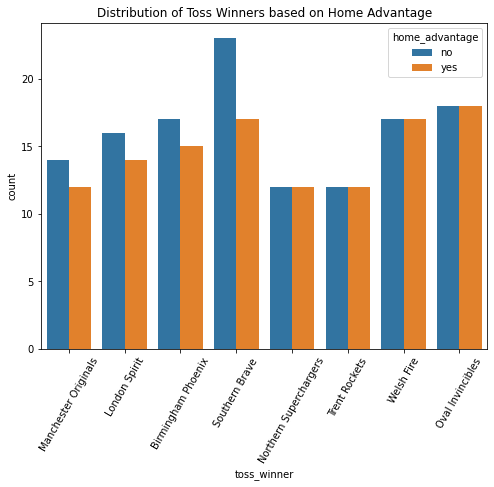

In [186]:
plt.figure(figsize=(8, 6))
sns.countplot(x="toss_winner", hue="home_advantage", data=df)
plt.title("Distribution of Toss Winners based on Home Advantage")
plt.xticks(rotation=60)
plt.show()

In [187]:
#An attempt was made to investigate the interaction between the variables toss_winner and home_advantage 
#using a logistic regression model
#but based on the fitted results p-values were found to be insignificant for both

toss_winner_dummies = pd.get_dummies(df['toss_winner'], prefix='toss_winner', drop_first=True)
df['home_advantage_dummy'] = df['home_advantage'].map({'yes': 1, 'no': 0}) #Convert to binary encoding

X = pd.concat([df['home_advantage_dummy'], toss_winner_dummies], axis=1)
X = sm.add_constant(X)

y = df['Result'].map({'win': 1, 'loose': 0}) #Convert to binary encoding

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.687521
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Result   No. Observations:                  246
Model:                          Logit   Df Residuals:                      237
Method:                           MLE   Df Model:                            8
Date:                Fri, 26 May 2023   Pseudo R-squ.:                0.008117
Time:                        22:38:19   Log-Likelihood:                -169.13
converged:                       True   LL-Null:                       -170.51
Covariance Type:            nonrobust   LLR p-value:                    0.9481
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.1999      0.375    

According to the results of this logistic regression model, the home advantage and toss_winner variables have a low predictive power for the match outcome and no significant association can be found.

I also thought about adding umpires to the data frame and looking at the 4 umpires as a combination to analyse the relationship with the number of team victories, but through the visualisation it did not seem to have a significant relationship, so I removed this variable.

The following is a previous visual analysis of the variable 'umpire'

In [57]:
# df['umpire_combination'] = df['all_umpires'].apply(lambda umpires: ' '.join(sorted(umpires)))
# df['umpire_combination']

0      J Naeem NL Bainton RT Robinson S Cummings S Re...
1      J Naeem NL Bainton RT Robinson S Cummings S Re...
2      DA Cosker DJ Millns MJ Saggers NJ Llong RJ Warren
3      DA Cosker DJ Millns MJ Saggers NJ Llong RJ Warren
4      A Harris J Naeem JJ Whitaker NL Bainton RJ Bailey
                             ...                        
243    AY Harris GD Lloyd J Ibbotson SJ Davis SJ O'Sh...
244    BJ Debenham M Burns MJ Saggers NJ Llong Phil W...
245    BJ Debenham M Burns MJ Saggers NJ Llong Phil W...
246    BJ Debenham J Naeem NJ Llong S Redfern Wayne Noon
247    BJ Debenham J Naeem NJ Llong S Redfern Wayne Noon
Name: umpire_combination, Length: 248, dtype: object

In [58]:
# win_counts = df[df['Result'] == 'win'].groupby(['team', 'umpire_combination']).size().unstack(fill_value=0)
# win_counts

umpire_combination,A Harris J Ibbotson MJ Saggers SJ Davis SJ O'Shaughnessy,A Harris J Naeem JJ Whitaker NL Bainton RJ Bailey,AC Harris James Middlebrook M Burns SJ O'Shaughnessy WR Smith,AG Wharf AY Harris NJ Llong SJ Davis Y Dolphin-Cooper,AG Wharf BJ Debenham DA Cosker DJ Millns NL Bainton,AG Wharf BV Taylor Phil Whitticase S McLelland S Redfern,AG Wharf CA Polosak G Bambury ID Blackwell Phil Whitticase,AG Wharf Chris Watts DA Cosker DJ Millns PR Pollard,AG Wharf DA Cosker GD Lloyd RJ Warren SJ O'Shaughnessy,AG Wharf DA Cosker NJ Llong NL Bainton RJ Bailey,...,NA Mallender NGB Cook NL Bainton RT Robinson Wayne Noon,NA Mallender PK Baldwin PM Such S Redfern SM Bartlett,NA Mallender PK Baldwin RJ Bailey RT Robinson S Cummings,NA Mallender RJ Warren RT Robinson S Cummings SJ O'Shaughnessy,NGB Cook RT Robinson S McLelland S Redfern TJ Boon,NJ Llong NL Bainton PM Such S Redfern Y Dolphin-Cooper,NJ Llong Phil Whitticase RJ Bailey RT Robinson SJ O'Shaughnessy,NJ Llong Rob White S McLelland SJ Davis SM Bartlett,PK Baldwin Phil Whitticase RJ Warren RT Robinson SJ O'Shaughnessy,PK Baldwin RJ Warren S Redfern SG Hinks SM Bartlett
team,,,,,,,,,,,,,,,,,,,,,
Birmingham Phoenix,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,1
London Spirit,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Manchester Originals,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,0,1,0,0,0,0
Northern Superchargers,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Oval Invincibles,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
Southern Brave,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Trent Rockets,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Welsh Fire,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


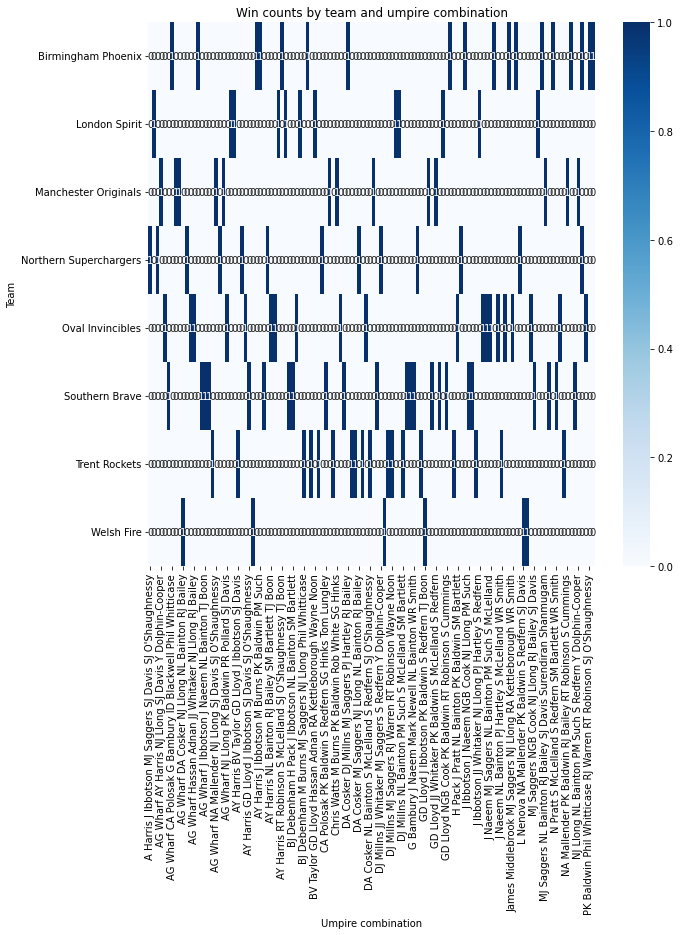

In [59]:
# plt.figure(figsize=(10, 10))
# sns.heatmap(win_counts, annot=True, fmt='d', cmap='Blues')
# plt.title('Win counts by team and umpire combination')
# plt.xlabel('Umpire combination')
# plt.ylabel('Team')
# plt.show()